## Imports

In [24]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import regex as re

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

#from google.colab import drive
#drive.mount('/content/drive/')

In [ ]:
!ls

drive  sample_data  UTKFaces


## Data Loading to Colab

In [ ]:
zip_path = "/content/drive/My Drive/UTKFace/UTKFace.zip"

!mkdir UTKFaces

%cd UTKFaces

/content/UTKFaces


In [ ]:
!cp "{zip_path}" .

!unzip -q UTKFace.zip

!rm UTKFace.zip

## Load/Show Functions

In [55]:
def load_images_from_folder(folder_path,height=200, width=200):
    filenames = [f for f in os.listdir(folder_path) if not f.startswith('.')]
    filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
    images = []
    
    for filename in filenames:
        img_cv = cv2.imread(os.path.join(folder_path,filename))
        if img_cv is not None:
            img = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (height, width))
            images.append(img)
    return images

In [26]:
def load_image_data_into_dataframe(folderpath):
    filenames = [f for f in os.listdir(folder_path)]
    filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
    df = pd.DataFrame()
    
    for filename in filenames:
        parsed_name = filename.split('_')
        df = df.append({'age' : int(parsed_name[0])
                       #,'gender' : parsed_name[1],
                       #'race' : parsed_name[2],
                        },ignore_index=True)
        
    #df['gender'] = df['gender'].map({'0': 'male', '1': 'female'})
    #df['race'] = df['race'].map({'0': 'White', '1': 'Black', '2': 'Asian', '3': 'Indian', '4': 'Others'})
    
    return df

In [27]:
def show_images(img_list,img_df):
    n=int(len(img_list)/5) +1 
    f = plt.figure(figsize=(25,n*5))
    
    for i,img in enumerate(img_list):
        f.add_subplot(n, 5, i + 1)
        plt.title(f'Age: {img_df.iloc[i]["age"]}; Race: {img_df.iloc[i]["race"]} Index: {i}',
                  fontweight="bold",fontsize=15)
        plt.imshow(img)

## Dataset Loading

In [50]:
folder_path = '../data/UTKFace/'

In [51]:
# Loading the Images 
images=load_images_from_folder(folder_path,height=200, width=200)
print("Images Loaded")

Images Loaded


In [30]:
# Loading the 3 features
features = load_image_data_into_dataframe(folder_path)
print("Dataframe Loaded")

Dataframe Loaded


In [31]:
print(len(images))
print(images[0].shape)
print(len(features))

22006
(200, 200, 3)
22006


## Visualization

In [ ]:
#show_images(images[500:520],features.iloc[500:520])

## Distribution

In [ ]:
f = plt.figure(figsize=(25,15))
bins_value=[1,5,19,25,27,30,34,39,49,59,80]
bins_value=[1,2,5,11,19,24,26,27,29,31,34,36,39,44,50,55,61,70,80]
#bins_value = list(range(0,85,5))

# Age Histogram
f.add_subplot(211)
sns.histplot(data=features,x = 'age', bins=bins_value)
plt.title('Age Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Age',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(bins_value, rotation = 25)

# Gender Histogram
f.add_subplot(223)
sns.histplot(features['gender'])
plt.title('Gender Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Gender',fontsize=20)
plt.ylabel('Frequency',fontsize=20)

# Race Histogram
f.add_subplot(224)
sns.histplot(features['race'])
plt.title('Race Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Race',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks()

plt.show()

## Variable Setup

**1**. Flatten the images **(200,200,3)**
2. Labelling the target **1st Model (Age).**
3. PCA-Only Analysis
4. Splitting the Data
Later. Age is to be binned on **5y intervals** ([1,5],[6,10],[11,15],...,...,[76,80])
Later. To check: Verify if **(Age, Sex and Race)** can also be used as inputs

### Flatenning

In [52]:
img_array = np.array(images)

In [33]:
X = img_array.flatten().reshape(22006, img_array.shape[1]*img_array.shape[2]*img_array.shape[3])
X.shape

(22006, 120000)

In [15]:
del img_array
del images

### Labeling Age

In [6]:
features["age_group"] = pd.qcut(features['age'],10)

In [7]:
features.head()

,age,age_group
0,1.0,"(0.999, 5.0]"
1,1.0,"(0.999, 5.0]"
2,1.0,"(0.999, 5.0]"
3,1.0,"(0.999, 5.0]"
4,1.0,"(0.999, 5.0]"


In [8]:
lbl = LabelEncoder()

In [9]:
lbl.fit(features['age_group'])

LabelEncoder()

In [10]:
y = lbl.transform(features['age_group'])

In [20]:
y

AttributeError: 'numpy.ndarray' object has no attribute 'value'

In [21]:
del features
del lbl

## PCA-Only Analysis

#### Incremental PCA on partial_fit

In [35]:
from sklearn.decomposition import IncrementalPCA

In [42]:
num_rows, num_columns = X.shape
#batch_size = 1000     # how many rows at a time to feed ipca
n_components = 245

pca = IncrementalPCA(copy=False,
                  n_components=n_components
                  ,batch_size=1000)

print(num_rows // batch_size)

22


In [44]:
pca.partial_fit(X[:500])

IncrementalPCA(batch_size=1000, copy=False, n_components=245)

In [38]:
#for i in range(0, num_rows//batch_size):
#    print(i,"/",num_rows//batch_size)
#    pca.partial_fit(X[i*batch_size : (i+1)*batch_size])

0 / 22
1 / 22


KeyboardInterrupt: 

In [ ]:
#data_projected = np.zeros((num_rows,n_components))

In [ ]:
#data_projected.shape

(22006, 500)

In [ ]:
#for i in range(0,num_rows//batch_size):
#    data_projected[i*batch_size:(i+1) * batch_size] = pca.transform(X[i*batch_size : (i+1)*batch_size])

#### TruncatedSVD

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd = TruncatedSVD(n_components=250)

In [ ]:
svd.fit(images_input)

In [ ]:
data_projected = svd.transform(images_input)

### Model Saving

In [ ]:
import joblib

In [ ]:
!ls

drive  sample_data  UTKFaces


In [ ]:
%model_name = "ipca_"+str(n_components)+".joblib"
model_name

'ipca_1000.joblib'

In [ ]:
model_name = "ipca_"+str(n_components)+".joblib"
joblib.dump(pca, model_name)

['ipca_1000.joblib']

In [ ]:
!ls

drive  ipca_1000.joblib  sample_data  UTKFaces


### 3. PCA Analysis

#### PCA Reconstruction

In [ ]:
#data_reconstruced = pca.inverse_transform(data_projected[:200])
#data_reconstruced.shape

In [ ]:
data_reconstruced = np.zeros((num_rows,num_columns))

In [ ]:
for i in range(0,num_rows//chunk_size):
    data_reconstruced[i*chunk_size:(i+1) * chunk_size] = pca.inverse_transform(data_projected[i*chunk_size : (i+1)*chunk_size])

NameError: ignored

In [189]:
plt.imshow((data_reconstruced[110].reshape((img_array.shape[1],img_array.shape[2],img_array.shape[3]))).astype(np.uint8))

NameError: ignored

In [ ]:
plt.imshow(images[110])

NameError: ignored

#### PCA Mean Faces

Text(0.5, 1.0, 'Mean Face of the Input')

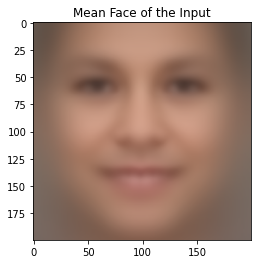

In [53]:
plt.imshow(np.mean(X,axis=0).reshape((img_array.shape[1],img_array.shape[2],img_array.shape[3])).astype(np.uint8))
plt.title("Mean Face of the Input")

Text(0.5, 1.0, 'Mean Face of the PCA')

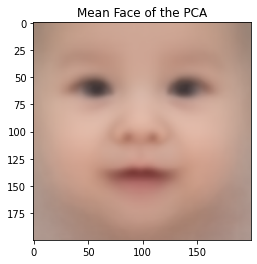

In [54]:
plt.imshow(pca.mean_.reshape((img_array.shape[1],img_array.shape[2],img_array.shape[3])).astype(np.uint8))
plt.title("Mean Face of the PCA")

#### PCA Components

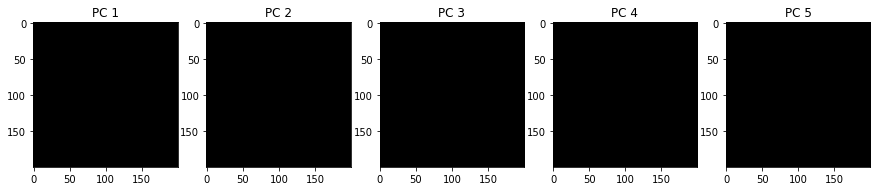

In [56]:
fig = plt.figure(figsize=(15,20))
for i in range(0,5):
    plt.subplot(1, 5, i + 1)
    plt.title(f'PC {i+1}', size=12)
    plt.imshow(pca.components_[i].reshape((img_array.shape[1],img_array.shape[2],img_array.shape[3])).astype(np.uint8))

In [75]:
plt.imshow(pca.components_[240].reshape(img_array.shape[1],img_array.shape[2],img_array.shape[3]), cmap=plt.cm.coolwarm)

SyntaxError: invalid syntax (<ipython-input-75-e655072f029e>, line 1)

In [62]:
pca.components_[150]

array([ 0.00980825,  0.00992892,  0.01250733, ..., -0.00763563,
       -0.00519442, -0.00594627])

#### Choosing the number of PCA Components

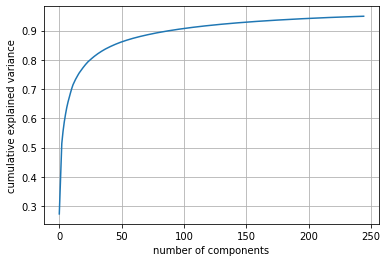

In [193]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

In [194]:
#Minimal Number of PC components required to explain g variance

g = 0.95

cumulated_variance = np.cumsum(pca.explained_variance_ratio_)
minimal_pc_count = len(cumulated_variance[cumulated_variance <= g]) + 1 # fill with the right answer
minimal_pc_count

246

## 4 Splitting the Data

In [24]:
# y has already been defined on the Labelling Age Section
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) 

NameError: name 'X' is not defined

In [23]:
del images_input

## Classifying the Data

### PCA fit on the train set and transform on both

In [21]:
from sklearn.decomposition import IncrementalPCA

In [22]:
X_test.shape

NameError: name 'X_test' is not defined

In [32]:
num_rows, num_columns = X_train.shape
chunk_size = 650      # how many rows at a time to feed ipca
n_components = 245    # 245 explains 95% variance on the 200x200 RBG Images

pca = IncrementalPCA(copy=False,
                  n_components=n_components
                  )

print(num_rows//chunk_size)

30


In [ ]:
for i in range(0, num_rows//chunk_size):
    print(i)
    pca.partial_fit(X_train[i*chunk_size : (i+1)*chunk_size])

0
1


In [30]:
X_train_transformed = np.zeros((X_train.shape[0],n_components))
X_test_transformed = np.zeros((X_test.shape[0],n_components))

In [31]:
for i in range(0,X_train_transformed.shape[0]//chunk_size):
    X_train_transformed[i*chunk_size:(i+1) * chunk_size] = pca.transform(X_train[i*chunk_size : (i+1)*chunk_size])

NotFittedError: This IncrementalPCA instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
for i in range(0,X_test_transformed.shape[1]//chunk_size):
    X_test_transformed[i*chunk_size:(i+1) * chunk_size] = pca.transform(X_test[i*chunk_size : (i+1)*chunk_size])

In [ ]:
del X_train,X_test

### Numpy Loads from the PCA Fit

In [3]:
pca_path = "../data/pca_files/"
X_test_transformed = np.load(pca_path+"X_test_transformed.npy")
X_train_transformed = np.load(pca_path+"X_train_transformed.npy")
y_test = np.load(pca_path+"y_test.npy")
y_train = np.load(pca_path+"y_train.npy")
print(X_train_transformed.shape)
print(X_test_transformed.shape)
print(y_train.shape)
print(y_test.shape)

(19805, 245)
(2201, 245)
(19805,)
(2201,)


### SVC Fitting!!

In [5]:
from sklearn.svm import LinearSVC

In [22]:
#param_grid = {
#    "kernel": ["linear", "rbf", "sigmoid", "poly"],
#    "C": [10, 20, 50, 100, 200, 500, 1000, 2000, 5000],
#    "gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}

#clf = GridSearchCV(SVC(class_weight="balanced",decision_function_shape='ovo')
#                        , param_grid, cv=5, n_jobs=-1, scoring="accuracy")

#clf = SVC(decision_function_shape='ovo')
#clf = SVC(decision_function_shape='ovo')
svc = SVC(probability=True)

In [20]:
print(X_train_transformed.shape,".......",type(X_train_transformed))
print(y_train.shape,".....",type(y_train))

(19805, 245) ....... <class 'numpy.ndarray'>
(19805,) ..... <class 'numpy.ndarray'>


In [11]:
pd.DataFrame(y_train).value_counts()

2    2502
0    2088
5    1987
6    1968
7    1955
9    1926
8    1923
1    1886
3    1823
4    1747
dtype: int64

In [23]:
# Fitting
svc.fit(X_train_transformed, y_train)

SVC(probability=True)

In [15]:
pd.DataFrame(y_test).value_counts()

2    293
9    237
1    235
0    220
7    210
3    208
5    206
8    201
6    200
4    191
dtype: int64

### Classification Report

In [ ]:
pd.DataFrame(y_train).value_counts()

In [18]:
y_pred = svc.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       220
           1       0.00      0.00      0.00       235
           2       0.13      1.00      0.23       293
           3       0.00      0.00      0.00       208
           4       0.00      0.00      0.00       191
           5       0.00      0.00      0.00       206
           6       0.00      0.00      0.00       200
           7       0.00      0.00      0.00       210
           8       0.00      0.00      0.00       201
           9       0.00      0.00      0.00       237

    accuracy                           0.13      2201
   macro avg       0.01      0.10      0.02      2201
weighted avg       0.02      0.13      0.03      2201



/home/fruntxas/.pyenv/versions/3.8.6/envs/agedetection/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fruntxas/.pyenv/versions/3.8.6/envs/agedetection/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fruntxas/.pyenv/versions/3.8.6/envs/agedetection/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [ ]:
#pd.DataFrame(y_pred).value_counts()
#clf.score(X_test_transformed,y_test)
#accuracy_score(y_test,y_pred)
clf.score(X_test_transformed,y_test)

### Further Improvement

In [ ]:
pipe = make_pipeline(PCA(),SVC(class_weight="balanced"))
param_grid = {
    "pca__n_components": range(200, 600, 1),
    "svc__kernel": ["linear"],
    "svc__C": [10],#[10, 20, 50, 100, 200, 500, 1000, 2000, 5000],
    "svc__gamma": [0.0001]#[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}

clf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')

In [ ]:
clf = clf.fit(X_train, y_train)

In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').head(20)

In [ ]:
clf.best_estimator_

In [ ]:
clf.best_estimator_.score(X_test, y_test)

In [ ]:
y_pred = clf.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

In [ ]:
# Number of Components that give out the best score
best_n_components = clf.get_params()['pca__n_components']
best_n_components